<a href="https://colab.research.google.com/github/damianmtz98/PyCdeD/blob/main/T2_AnalisisSent_Reviews_Netflix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tarea 2: Análisis de Sentimiento



## Visualización de datos

In [ ]:
#Utilidades
import pandas as pd
import numpy as np
from datetime import datetime
from collections import Counter

#Visualización
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

#Preprocesamiento
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer, SnowballStemmer

from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
!pip install nltk  # Esta línea instala nltk y generalmente se coloca al inicio del script o en un entorno de configuración, no dentro del código principal.
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [ ]:
# Lectura de datos
df = pd.read_csv('netflix_reviews.csv', encoding='latin-1') # Try 'latin-1' encoding
df.head()

,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion
0,f9a3ae5c-48c6-4584-a598-d6f4bf42c290,Rick Newton,"Best ð. I installed it on all my devices, a...",5,0,8.117.0 build 3 50695,03/06/2024 22:09,8.117.0 build 3 50695
1,51814674-129a-41cb-a22d-4f338de79268,Demonpriest -,"After the 5/29 update, NOTHING will play on my...",1,0,8.117.0 build 3 50695,03/06/2024 21:54,8.117.0 build 3 50695
2,1468727b-5508-48ea-8709-6b6804e04c30,Mari Marcheschi (ObsoleteAngel),"For the past couple months, I have not been ab...",1,0,8.117.0 build 3 50695,03/06/2024 21:44,8.117.0 build 3 50695
3,6d49f42a-6c85-4744-b01a-81c7fe7a35c5,Rodyna Ramy,I am a Netflix addict especially jurrasic worl...,5,0,NaN,03/06/2024 21:41,NaN
4,d3e279f0-57ce-44f3-8dc3-2bb2405c5653,Keke Love,I love they tv shows and movies 10\10,5,0,8.117.0 build 3 50695,03/06/2024 21:34,8.117.0 build 3 50695


In [ ]:
# seleccionamos las columnas de interes y las renombramos
reviews_net = df[['reviewId', 'content', 'at']]
reviews_net.columns = ['id', 'texto', 'fecha']
reviews_net.head()

,id,texto,fecha
0,f9a3ae5c-48c6-4584-a598-d6f4bf42c290,"Best ð. I installed it on all my devices, a...",03/06/2024 22:09
1,51814674-129a-41cb-a22d-4f338de79268,"After the 5/29 update, NOTHING will play on my...",03/06/2024 21:54
2,1468727b-5508-48ea-8709-6b6804e04c30,"For the past couple months, I have not been ab...",03/06/2024 21:44
3,6d49f42a-6c85-4744-b01a-81c7fe7a35c5,I am a Netflix addict especially jurrasic worl...,03/06/2024 21:41
4,d3e279f0-57ce-44f3-8dc3-2bb2405c5653,I love they tv shows and movies 10\10,03/06/2024 21:34


In [ ]:
# damos formato a la fecha
reviews_net['fecha'] = pd.to_datetime(reviews_net['fecha'], format='%d/%m/%Y %H:%M')
reviews_net['fecha'] = reviews_net['fecha'].dt.strftime('%Y-%m-%d')
reviews_net.head(3)

<ipython-input-16-9e06f55e41f6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_net['fecha'] = pd.to_datetime(reviews_net['fecha'], format='%d/%m/%Y %H:%M')
<ipython-input-16-9e06f55e41f6>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_net['fecha'] = reviews_net['fecha'].dt.strftime('%Y-%m-%d')


,id,texto,fecha
0,f9a3ae5c-48c6-4584-a598-d6f4bf42c290,"Best ð. I installed it on all my devices, a...",2024-06-03
1,51814674-129a-41cb-a22d-4f338de79268,"After the 5/29 update, NOTHING will play on my...",2024-06-03
2,1468727b-5508-48ea-8709-6b6804e04c30,"For the past couple months, I have not been ab...",2024-06-03


## Distribución de las reseñas


In [ ]:
# distribución temporal de las reseñas

conteo_reviews = Counter(reviews_net.fecha)

# buscamos obtener las fechas y la cantidad de reviews
fechas_unicas = sorted(conteo_reviews.keys())
cantidad_reviews = [conteo_reviews[fecha] for fecha in fechas_unicas]
fechas_unicas = [datetime.strptime(fecha, "%Y-%m-%d") for fecha in fechas_unicas]

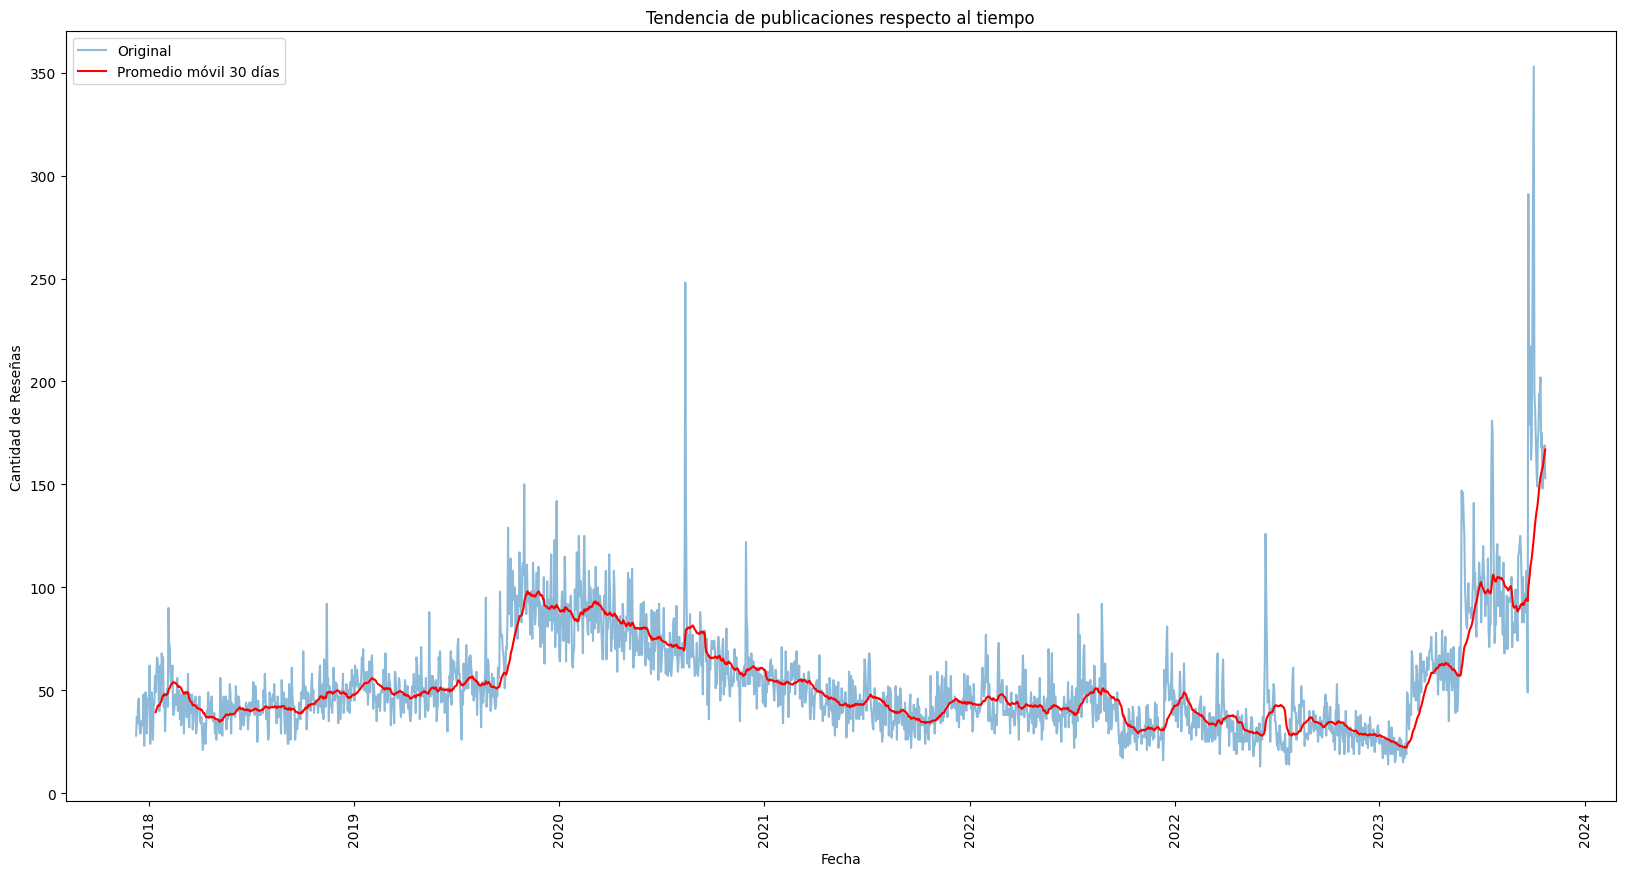

In [ ]:
data = pd.DataFrame({
    'Fecha': pd.to_datetime(fechas_unicas),
    'Reviews': cantidad_reviews
})

# ordenar fechas
data.sort_values('Fecha', inplace=True)

# calculamos promedio móvil de 30 días
data['SMA_30'] = data['Reviews'].rolling(window=30).mean()

# creaamos el gráfico
plt.figure(figsize=(20, 10))
plt.plot(data['Fecha'], data['Reviews'], label='Original', alpha=0.5)
plt.plot(data['Fecha'], data['SMA_30'], label='Promedio móvil 30 días', color='red')

# formateamos el eje X para fecha
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=10))  # Intervalo cada mes

plt.xlabel('Fecha')
plt.ylabel('Cantidad de Reseñas')
plt.title('Tendencia de publicaciones respecto al tiempo')
plt.xticks(rotation=90)  # Girar las etiquetas del eje X para mayor legibilidad


plt.legend()

plt.show()


##Preprocesamiento

In [ ]:
stop_words = set(stopwords.words('english'))

def wordnet_words(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

def texto_limpio(text):
  # manejamos posibles valores flotantes
    if isinstance(text, float):
        text = str(text)  # convertimos flotante a cadena si es necesario
    # convertir el texto a minúsculas
    text = text.lower()

    # eliminar puntuación y números
    text = re.sub(r'\d+', '', text)  # números
    text = re.sub(r'[^\w\s]|ð', '', text)  # puntuación

    # eliminar stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])

    # eliminar espacios vacíos
    text = text.strip()
    text = re.sub(r'\s+', ' ', text)  # múltiples espacios por uno solo

    return text

# aplicamps la función de limpieza al dataframe
reviews_net['texto_limpio'] = reviews_net['texto'].apply(texto_limpio)
reviews_net.head(100)

<ipython-input-29-2eb1f848910a>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_net['texto_limpio'] = reviews_net['texto'].apply(texto_limpio)


,id,texto,fecha,texto_limpio,texto_lematizado
0,f9a3ae5c-48c6-4584-a598-d6f4bf42c290,"Best ð. I installed it on all my devices, a...",2024-06-03,best installed devices hope people agree pleas...,best instal device hope people agree please make
1,51814674-129a-41cb-a22d-4f338de79268,"After the 5/29 update, NOTHING will play on my...",2024-06-03,update nothing play phone,update nothing play phone
2,1468727b-5508-48ea-8709-6b6804e04c30,"For the past couple months, I have not been ab...",2024-06-03,past couple months able even open netflix give...,past couple month able even open netflix give ...
3,6d49f42a-6c85-4744-b01a-81c7fe7a35c5,I am a Netflix addict especially jurrasic worl...,2024-06-03,netflix addict especially jurrasic world camp ...,netflix addict especially jurrasic world camp ...
4,d3e279f0-57ce-44f3-8dc3-2bb2405c5653,I love they tv shows and movies 10\10,2024-06-03,love tv shows movies,love tv show movie
...,...,...,...,...,...
95,856a8f4c-9123-42a1-9076-0a53c7fed890,Not please that I've been trying to subscribe ...,2024-06-03,please ive trying subscribe netflix account ke...,please ive try subscribe netflix account keep ...
96,ff625318-7edd-478d-b599-418a21b36f16,Good form my ðððð¸ð¸,2024-06-03,good form,good form
97,a4fda499-b85b-43e1-a12d-9188914ea8a4,Plz upload more koraen daramas dubbing,2024-06-03,plz upload koraen daramas dubbing,plz upload koraen daramas dub
98,8a10bf7c-558c-4d87-91d2-5772fb6a642a,Search function of Netflix is very very bad ex...,2024-06-03,search function netflix bad experience please ...,search function netflix bad experience please ...


## Tokenización y lematización

In [ ]:
def tokenizar_lem(text):
    # tokenizamos el texto
    words = word_tokenize(text)

    # lematizamos cada palabra con la etiqueta POS adecuada
    lem = WordNetLemmatizer()
    lema = [lem.lemmatize(w, wordnet_words(w)) for w in words]
    return ' '.join(lema)

# Aplicar la función de tokenización y lematización a la columna 'texto_limpio'
reviews_net['texto_lematizado'] = reviews_net['texto_limpio'].apply(tokenizar_lem)
reviews_net.head()


<ipython-input-30-a633a4e2404e>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews_net['texto_lematizado'] = reviews_net['texto_limpio'].apply(tokenizar_lem)


,id,texto,fecha,texto_limpio,texto_lematizado
0,f9a3ae5c-48c6-4584-a598-d6f4bf42c290,"Best ð. I installed it on all my devices, a...",2024-06-03,best installed devices hope people agree pleas...,best instal device hope people agree please make
1,51814674-129a-41cb-a22d-4f338de79268,"After the 5/29 update, NOTHING will play on my...",2024-06-03,update nothing play phone,update nothing play phone
2,1468727b-5508-48ea-8709-6b6804e04c30,"For the past couple months, I have not been ab...",2024-06-03,past couple months able even open netflix give...,past couple month able even open netflix give ...
3,6d49f42a-6c85-4744-b01a-81c7fe7a35c5,I am a Netflix addict especially jurrasic worl...,2024-06-03,netflix addict especially jurrasic world camp ...,netflix addict especially jurrasic world camp ...
4,d3e279f0-57ce-44f3-8dc3-2bb2405c5653,I love they tv shows and movies 10\10,2024-06-03,love tv shows movies,love tv show movie


## Conteo de frecuencias

In [ ]:
# concatenamos todos los textos lematizados en una sola cadena
textos_juntos = ' '.join(reviews_net['texto_lematizado'])

# tokenizamos los textos juntos
words = word_tokenize(textos_juntos)

# Crear un contador para todas las palabras
word_counts = Counter(words)

# Mostrar las 10 palabras más comunes
most_common_words = word_counts.most_common(20)
print(most_common_words)


[('netflix', 49188), ('app', 49058), ('watch', 36124), ('movie', 35716), ('show', 29371), ('good', 17972), ('like', 16977), ('get', 16884), ('love', 15182), ('use', 15092), ('cant', 14565), ('work', 14445), ('please', 12543), ('time', 12513), ('update', 12244), ('dont', 11832), ('great', 11458), ('phone', 10930), ('even', 10913), ('try', 10527)]


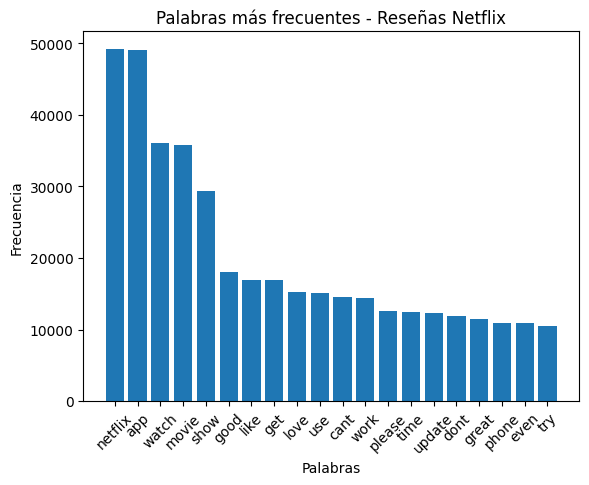

In [ ]:
# extraemos palabras y frecuencias
words = [word[0] for word in most_common_words]
frequencies = [word[1] for word in most_common_words]


plt.bar(words, frequencies)
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')
plt.title('Palabras más frecuentes - Reseñas Netflix')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# palabras para excluir
palabras_excluir = {'netflix', 'app'}

In [ ]:
# función para contar palabras y aplicamos el filtro de las palabras que queremos excluir
def contar_palabras(textos):
    palabras = word_tokenize(' '.join(textos))
    filtro_palabras = [word for word in palabras if word not in palabras_excluir]
    return Counter(filtro_palabras)

<ipython-input-72-d3e7efaae602>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(palabras, rotation=45, ha='right')


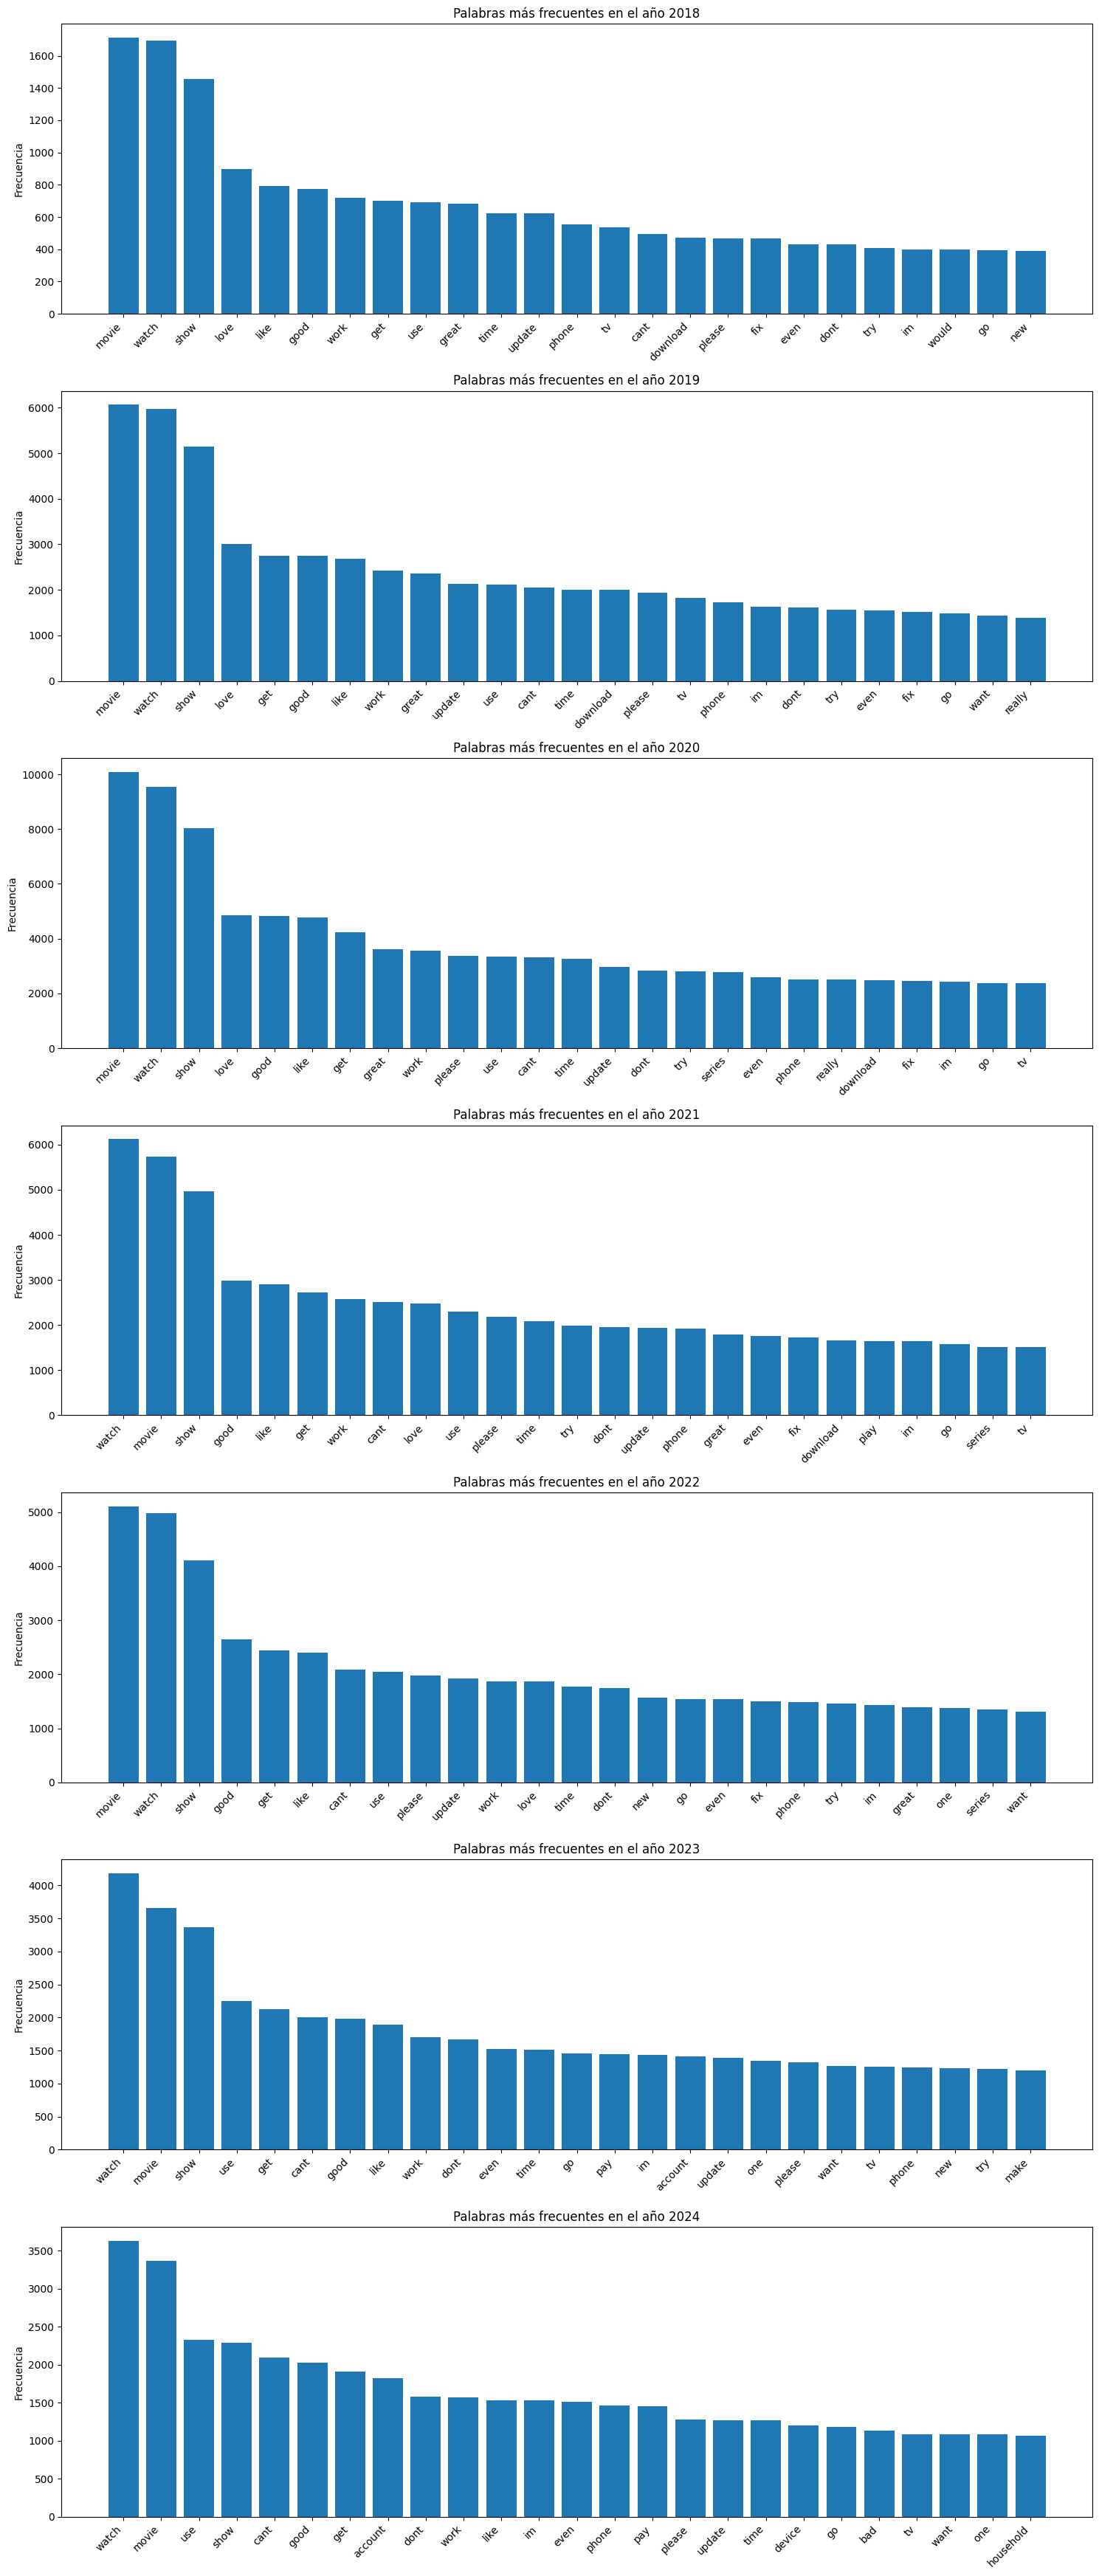

In [ ]:
# agrupamos por año y aplicamos el conteo de palabras
conteo_por_año = reviews_net.groupby('año')['texto_lematizado'].agg(lambda texts: contar_palabras(texts))

# número de palabras que queremos mostrar
top_n = 25

# creamos una figura y un conjunto de subplots
fig, axes = plt.subplots(nrows=len(conteo_por_año), ncols=1, figsize=(15, 5 * len(conteo_por_año)))


# obtenemos las palabras más comunes para el año
for ax, (año, conteo) in zip(axes.flatten(), conteo_por_año.items()):
    palabras_comunes = conteo.most_common(top_n)
    palabras, frecuencias = zip(*palabras_comunes)

    # Crear gráfico de barras
    ax.bar(palabras, frecuencias)
    ax.set_title(f'Palabras más frecuentes en el año {año}')
    ax.set_ylabel('Frecuencia')
    ax.set_xticklabels(palabras, rotation=45, ha='right')

# Ajustar layout para evitar solapamientos
plt.tight_layout()
plt.show()


## Vectorización

In [ ]:
# configuramos el countvectorizer
vectorizer = CountVectorizer(ngram_range=(2, 2),  # Uso de unigramas y bigramas
                             stop_words=list(palabras_excluir),  # Excluir palabras específicas
                             max_features=1000)  # Limitar el número de características para mantener las más relevantes

# Aplicar el vectorizador al texto lematizado
ngram_matrix = vectorizer.fit_transform(reviews_net['texto_lematizado'])

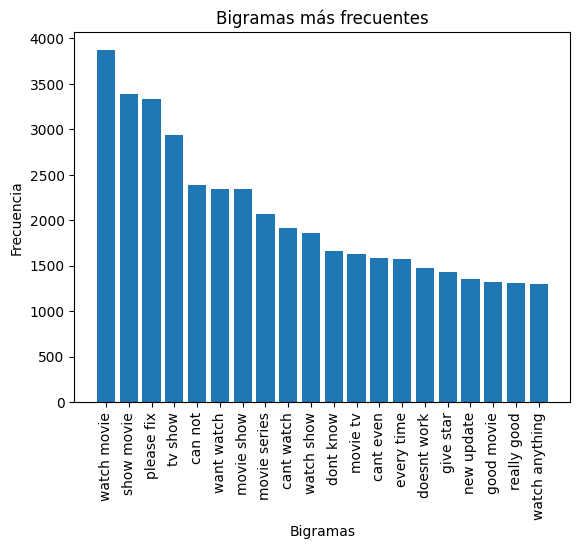

In [ ]:
# sumamos las frecuencias de cada n-gram
sums = np.sum(ngram_matrix, axis=0)
words_freq = [(word, sums[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

# n-grams más frecuentes para visualizar
top_ngrams = words_freq[:20]
words, freqs = zip(*top_ngrams)


plt.bar(words, freqs)
plt.xlabel('Bigramas')
plt.ylabel('Frecuencia')
plt.title('Bigramas más frecuentes')
plt.xticks(rotation=90)
plt.show()


In [ ]:
sums = np.array(ngram_matrix.sum(axis=0)).flatten()
ngrams = vectorizer.get_feature_names_out()
df_ngrams = pd.DataFrame({'N-Gram': ngrams, 'Frecuencia': sums})
df_ngrams = df_ngrams.sort_values(by='Frecuencia', ascending=False)
df_ngrams.head(10)


,N-Gram,Frecuencia
929,watch movie,3870
724,show movie,3386
611,please fix,3336
831,tv show,2935
67,can not,2386
897,want watch,2344
491,movie show,2342
490,movie series,2066
92,cant watch,1918
937,watch show,1861


In [ ]:
# configuramos el countvectorizer
vectorizer = CountVectorizer(ngram_range=(3, 3), # trigrama
                             stop_words=list(palabras_excluir),
                             max_features=1000)

# aplicamos el vectorizador al texto lematizado
ngram_matrix = vectorizer.fit_transform(reviews_net['texto_lematizado'])

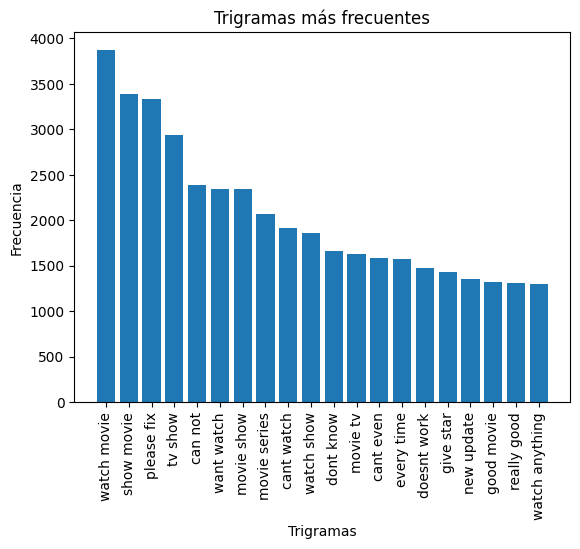

In [ ]:
# sumamos las frecuencias de cada n-gram
sums = np.sum(ngram_matrix, axis=0)
words_freq = [(word, sums[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

# n-grams más frecuentes para visualizar
top_ngrams = words_freq[:20]
words, freqs = zip(*top_ngrams)


plt.bar(words, freqs)
plt.xlabel('Trigramas')
plt.ylabel('Frecuencia')
plt.title('Trigramas más frecuentes')
plt.xticks(rotation=90)
plt.show()

In [ ]:
sums = np.array(ngram_matrix.sum(axis=0)).flatten()
ngrams = vectorizer.get_feature_names_out()
df_ngrams = pd.DataFrame({'N-Gram': ngrams, 'Frecuencia': sums})
df_ngrams = df_ngrams.sort_values(by='Frecuencia', ascending=False)
df_ngrams.head(10)


,N-Gram,Frecuencia
515,movie tv show,1233
826,tv show movie,531
620,please try later,459
154,could reach service,418
131,cant watch anything,370
752,since last update,358
763,sorry could reach,358
634,reach service please,338
709,service please try,326
606,please fix issue,323


## Análisis Sentimiento

In [ ]:
lexicon = pd.read_table(
    'https://raw.githubusercontent.com/fnielsen/afinn/master/afinn/data/AFINN-en-165.txt',
    names=['termino', 'sentimiento']
)

lexicon.head()


,termino,sentimiento
0,abandon,-2
1,abandoned,-2
2,abandons,-2
3,abducted,-2
4,abduction,-2


In [ ]:
#tokenizamos cada reseña y las llevamos a una nueva fila
df_tokens = reviews_net['texto_lematizado'].apply(word_tokenize).explode().reset_index().rename(columns={'texto_lematizado': 'token'})
df_tokens.columns = ['index', 'token']


In [ ]:
# unimos los tokens con el léxico
df_sentimiento = pd.merge(
    left=df_tokens,
    right=lexicon,
    left_on="token",
    right_on="termino",
    how="inner"
)


In [ ]:
df_sentimiento = pd.merge(
    df_sentimiento,
    reviews_net[['año']],
    left_on='index',
    right_index=True,
    how='left'
)

df_sentimiento

,index,token,termino,sentimiento,año_x,año_y,año
0,0,best,best,3,2024,2024,2024
1,14,best,best,3,2024,2024,2024
2,50,best,best,3,2024,2024,2024
3,69,best,best,3,2024,2024,2024
4,125,best,best,3,2024,2024,2024
...,...,...,...,...,...,...,...
277196,109514,frikin,frikin,-2,2020,2020,2020
277197,109978,criticizes,criticizes,-2,2019,2019,2019
277198,110373,underperform,underperform,-2,2020,2020,2020
277199,111029,applause,applause,2,2020,2020,2020


In [ ]:
def perfil_sentimientos(df):
    print(f"Año: {df.iloc[0]['año']}")
    print("=" * 12)
    print(f"Positivos: {round(100 * np.mean(df.sentimiento > 0), 2)}%")
    print(f"Neutros  : {round(100 * np.mean(df.sentimiento == 0), 2)}%")
    print(f"Negativos: {round(100 * np.mean(df.sentimiento < 0), 2)}%")
    print(" ")

for año, df_grupo in df_sentimiento.groupby("año"):
    perfil_sentimientos(df_grupo)


Año: 2018
Positivos: 68.79%
Neutros  : 0.0%
Negativos: 31.21%
 
Año: 2019
Positivos: 69.54%
Neutros  : 0.0%
Negativos: 30.46%
 
Año: 2020
Positivos: 69.76%
Neutros  : 0.0%
Negativos: 30.24%
 
Año: 2021
Positivos: 66.2%
Neutros  : 0.0%
Negativos: 33.8%
 
Año: 2022
Positivos: 64.69%
Neutros  : 0.0%
Negativos: 35.31%
 
Año: 2023
Positivos: 58.17%
Neutros  : 0.0%
Negativos: 41.83%
 
Año: 2024
Positivos: 57.32%
Neutros  : 0.0%
Negativos: 42.68%
 


In [ ]:
def calcular_proporciones(df):
    positivos = round(100 * np.mean(df.sentimiento > 0), 2)
    neutros = round(100 * np.mean(df.sentimiento == 0), 2)
    negativos = round(100 * np.mean(df.sentimiento < 0), 2)
    return positivos, neutros, negativos

# Ddiccionario para almacenar los resultados
resultados_sentimiento = {}

for año, df_grupo in df_sentimiento.groupby("año"):
    resultados_sentimiento[año] = calcular_proporciones(df_grupo)

# convertimos en dataframe
df_resultados = pd.DataFrame.from_dict(resultados_sentimiento, orient='index', columns=['Positivos', 'Neutros', 'Negativos'])


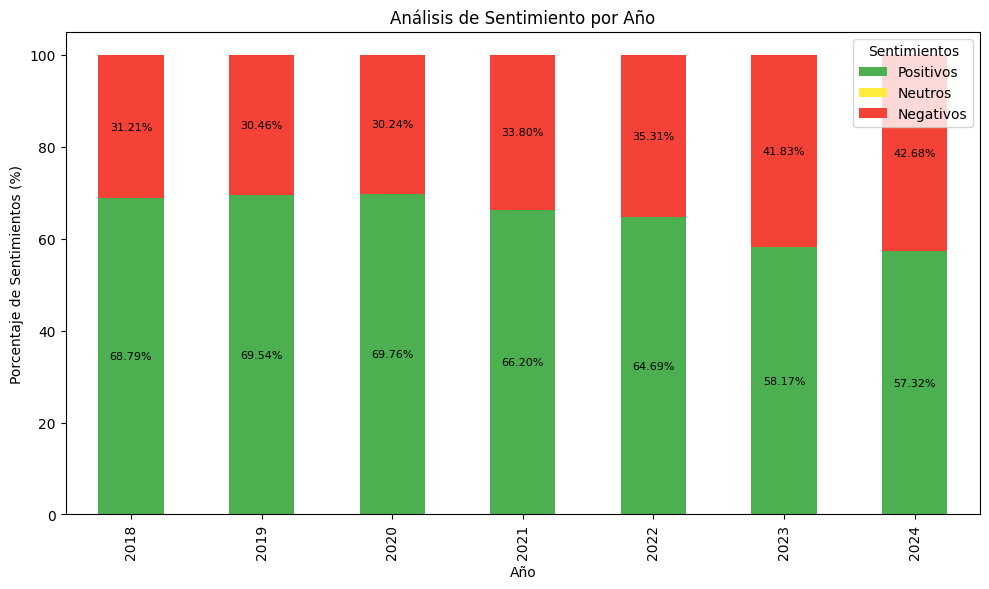

In [ ]:
busfig, ax = plt.subplots(figsize=(10, 6))

colors = ['#4CAF50', '#FFEB3B', '#F44336']


df_resultados.plot(kind='bar', stacked=True, color=colors, ax=ax)

ax.set_title('Análisis de Sentimiento por Año')
ax.set_xlabel('Año')
ax.set_ylabel('Porcentaje de Sentimientos (%)')
ax.legend(title='Sentimientos')


for i in ax.patches:

    height = i.get_height()
    width = i.get_width()
    x = i.get_x()
    y = i.get_y()

    label_text = f'{height:.2f}%'

    label_x = x + width / 2
    label_y = y + height / 2


    if height > 0:
        ax.text(label_x, label_y, label_text, ha='center', va='center', fontsize=8, color='black')

plt.tight_layout()
plt.show()
